In [22]:
# Lectura del conjunto de datos utilizando Pandas
import pandas as pd
from datetime import datetime
dolar = pd.read_csv('dolarMEP.csv')
df = pd.read_csv('lista_prestamos.csv')
df

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia
...,...,...,...,...,...,...,...,...,...
401,10/01/2018,Decoracion,45,21600,Buenos Aires,F,48,48,+180 dias
402,09/01/2018,Otros destinos,36,14000,Santa Fe,D,48,48,+180 dias
403,04/01/2018,Refaccion y construccion de vivienda,50,30000,Buenos Aires,E,48,48,+180 dias
404,04/01/2018,Refaccion y construccion de vivienda,35,32355,Ciudad de Buenos Aires,D,48,48,+180 dias


In [23]:
# Realizamos una copia del original para no trabajar sobre esta
df_orig= df.copy()
df.head()

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia


In [24]:
# vemos que tipo de datos tiene el data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Fecha            406 non-null    object
 1   Destino          406 non-null    object
 2   Edad             406 non-null    int64 
 3   Ingresos         406 non-null    int64 
 4   Zona geografica  406 non-null    object
 5   Perfil           406 non-null    object
 6   Plazo            406 non-null    int64 
 7   Cuota            406 non-null    int64 
 8   class            406 non-null    object
dtypes: int64(4), object(5)
memory usage: 28.7+ KB


In [25]:
# Al analizar la base de datos, tendremos que hacer varias modificaciones para representarlo correctamente 
# para ingresos lo pasaremos a dolares utilizando una base de dato donde tenemos según meses el valor máximo de valor mep
# con respecto a la cuota lo dividiremos por el plazo para tener un porcentaje de avance de los pagos 
# con respecto a clases dividiremos en los que son "Al dia" -> "bueno" y todos los demas como "malo"
# cuando ingresemos una nueva entrada lo pasaremos por esta función 

dolar_prueba = dolar.copy()
df_prueba= df.copy()



def editor_fichero(fichero,fichero_dolar):

    def convertir_etiqueta(fichero): #empezamos por class
        fichero.loc[fichero['class'] == 'Al dia', 'class'] = 'Bueno'
        fichero.loc[fichero['class'] != 'Bueno', 'class'] = 'malo'
        return fichero
    

    def convertir_cuota_en_porcentaje(fichero): #modificamos las cuotas por un porcentaje de avance del cuota/plazo
        fichero['porcentaje_Avance'] = fichero['Cuota']/fichero['Plazo']
        del fichero['Cuota']
        return fichero
    
    def pasar_ingresos_a_dolares(fichero, fichero_dolar):  #pasar a dolares los ingresos - sacamos el mayor dolar de cada mes y ese será el valor a convertir
       
        #transformamos las columnas de fecha a variable datetime
        fichero['Fecha']= pd.to_datetime(fichero['Fecha'])
        fichero_dolar['Fecha']=pd.to_datetime(fichero_dolar['Fecha'])

        #creamos una nueva columna del dolar para esa fecha en particular, luego los ingresos se dividiran por este dolar
        fichero['dolar']=""
        fichero['ingresos en dolares']=""

        for x in range(0,(len(fichero.index)),1):
            cond=False
            cont=0
            dia=pd.to_timedelta('1 days')


            while cond==False:
                cont=cont+1
                for y in range(0,(len(fichero_dolar.index)),1):
                    if (fichero.loc[(x,'Fecha')]+dia*cont)==fichero_dolar.loc[(y,'Fecha')]:
                        fichero.loc[(x,'dolar')] = fichero_dolar.loc[(y,'dolar')]
                        cond=True
                        break  

        fichero['ingresos en dolares'] = fichero['Ingresos'] / fichero['dolar']
        del fichero['Ingresos']
        del fichero['Fecha']
        del fichero['dolar']
        
        return fichero
    
    return pasar_ingresos_a_dolares(convertir_cuota_en_porcentaje(convertir_etiqueta(fichero)),fichero_dolar)


editor_fichero(df_prueba, dolar_prueba)
df_prueba




C:\Users\UDLEA\AppData\Local\Temp\ipykernel_8280\602188758.py:28: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fichero['Fecha']= pd.to_datetime(fichero['Fecha'])
C:\Users\UDLEA\AppData\Local\Temp\ipykernel_8280\602188758.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fichero_dolar['Fecha']=pd.to_datetime(fichero_dolar['Fecha'])


,Destino,Edad,Zona geografica,Perfil,Plazo,class,porcentaje_Avance,ingresos en dolares
0,Refaccion y construccion de vivienda,45,Buenos Aires,A,6,Bueno,0.166667,1974.450609
1,Decoracion,40,La Pampa,AA,6,Bueno,0.166667,4843.271727
2,Refaccion y construccion de vivienda,52,Rio Negro,AA,18,Bueno,0.055556,886.440774
3,Viaje,70,Corrientes,AA,18,Bueno,0.055556,416.547102
4,Refaccion y construccion de vivienda,57,Buenos Aires,C,6,Bueno,0.166667,289.999466
...,...,...,...,...,...,...,...,...
401,Decoracion,45,Buenos Aires,F,48,malo,1.000000,601.838952
402,Otros destinos,36,Santa Fe,D,48,malo,1.000000,370.860927
403,Refaccion y construccion de vivienda,50,Buenos Aires,E,48,malo,1.000000,1423.149905
404,Refaccion y construccion de vivienda,35,Ciudad de Buenos Aires,D,48,malo,1.000000,1534.867173


<Axes: >

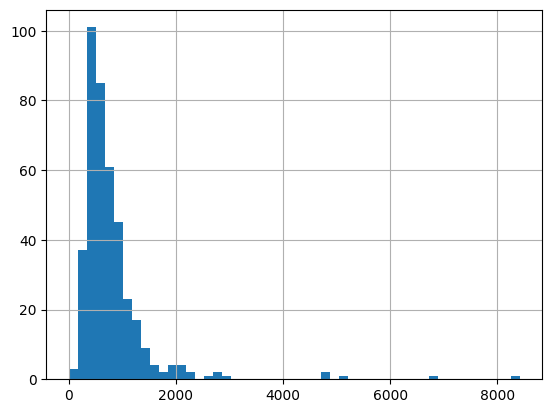

In [26]:
#transformaremos a travez de Sklearn ->LabelEncoder de valores categoricos a numéricos (Destino-Zona Geografica-Perfil-class)

# Mostrar los valores de la característica como un histograma
%matplotlib inline
import matplotlib.pyplot as plt
df_prueba["ingresos en dolares"].hist(bins=50)





<Axes: >

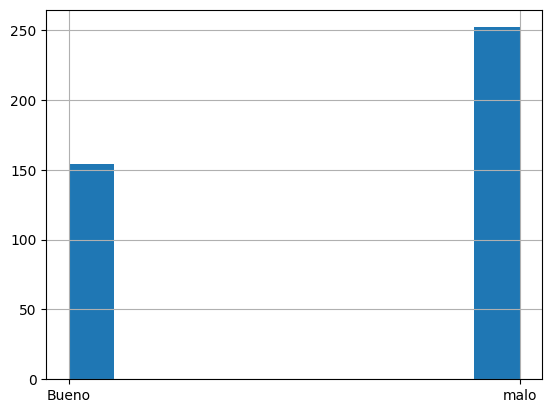

In [27]:
# Mostrar los valores de la característica como un histograma
%matplotlib inline
import matplotlib.pyplot as plt
df_prueba["class"].hist()

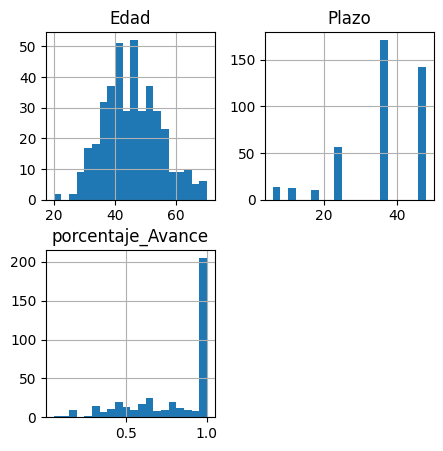

In [28]:
# Representar gráficamente la distribución de los atributos
df_prueba.hist(bins=20, figsize=(5,5))
plt.show()